In [11]:
# Loading libraries
from bayes_opt import BayesianOptimization as bo
import xgboost as xgb
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import warnings
warnings.simplefilter("ignore")
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import seaborn as sns
sns.set_style("ticks")
%matplotlib inline

# Bayesian Optimization

In [2]:
def _my_bayesian_optimization(X, Y, n_iter = 5,
                                       init_points = 5,
                                       acq = "ei",
                                       num_boost_round = 1000,
                                       nfold = 10,
                                       stratified = True,
                                       metrics = ("auc"),
                                       early_stopping_rounds = 20,
                                       seed = 1367,
                                       shuffle = True,
                                       show_stdv = False,
                                       pbounds = None,
                                       importance_type = "total_gain",
                                       callbacks = False,
                                       verbose_eval = False):
    """
    a function to run bayesian optimization for xgboost
    input parameters:
                    X: features (pandas dataframe or numpy array)
                    Y: targets (1D array or list)
                    n_iter: total number of bayesian iterations (default = 5)
                    init_points: total initial points of optimization (default = 5)
                    acq
                    num_boost_rounds: max number of boosting rounds, (default = 1000)
                    stratified: stratificaiton of the targets (default = True)
                    metrics: classification/regression metrics (default = ("auc))
                    early_stopping_rounds: the criteria for stopping if the test metric is not improved (default = 20)
                    seed: random seed (default = 1367)
                    shuffle: shuffling the data (default = True)
                    show_stdv = showing standard deviation of cv results (default = False)
                    pbounds = set of parameters for bayesian optimization of xgboost cv
                            (default_params = {
                                               "eval_metric" : "auc",
                                               "tree_method": "hist",
                                               "objective" : "binary:logistic",
                                               "learning_rate" : 0.05,
                                               "max_depth": 2,
                                               "min_child_weight": 1,
                                               "gamma" : 0.0,
                                               "reg_alpha" : 0.0,
                                               "reg_lambda" : 1.0,
                                               "subsample" : 0.9,
                                               "max_delta_step": 1,
                                               "silent" : 1,
                                               "nthread" : 4,
                                               "scale_pos_weight" : 1
                                               }
                            )
                    importance_type = importance type of xgboost as string (default = "total_gain")
                                      the other options will be "weight", "gain", "cover", and "total_cover"
                    callbacks = printing callbacks for xgboost cv
                                (defaults = False, if True: [xgb.callback.print_evaluation(show_stdv = show_stdv),
                                                             xgb.callback.early_stop(early_stopping_rounds)])
                    verbose_eval : a flag to show the result during train on train/test sets (default = False)
    outputs:
            df_res: the parameters related to the best performance
            xgb_params: a dictionary of the best parameters of xgboost                
    
    
    """

    
    # callback flag
    if(callbacks == True):
        callbacks = [xgb.callback.print_evaluation(show_stdv = show_stdv),
                     xgb.callback.early_stop(early_stopping_rounds)]
    else:
        callbacks = None    
    
    # pbounds
    default_pbounds = {"max_depth" : (2, 5),
                       "learning_rate" : (0, 1), 
                       "min_child_weight" : (1, 20),
                       "subsample" : (0.1, 1),
                       "gamma": (0, 1),
                       "colsample_bytree": (0.1, 1.0)
                      }
    
    # updating the default parameters of the pbounds
    if pbounds is not None:
        for key, val in pbounds.items():
            default_pbounds[key] = val
    
    
    def __xgb_eval(learning_rate,
                   max_depth,
                   gamma,
                   colsample_bytree,
                   min_child_weight,
                   subsample):

        params = {"eval_metric" : "auc",
                  "tree_method": "hist",
                  "objective" : "binary:logistic",
                  "max_delta_step": 1,
                  "silent" : 1,
                  "nthread" : 4,
                  "scale_pos_weight" : 1,
                  "reg_alpha" : 0.0,
                  "reg_lambda" : 1.0,
                  "learning_rate" : learning_rate,
                  "max_depth": int(max_depth),
                  "min_child_weight": min_child_weight,
                  "gamma" : gamma,
                  "subsample" : subsample,
                  "colsample_bytree" : colsample_bytree 
                 }
        dtrain = xgb.DMatrix(data = X, label = Y)
        cv_result = xgb.cv(params = params,
                           dtrain = dtrain,
                           num_boost_round = num_boost_round,
                           nfold = nfold,
                           stratified = stratified,
                           metrics = metrics,
                           early_stopping_rounds = early_stopping_rounds,
                           seed = seed,
                           verbose_eval = verbose_eval,
                           shuffle = shuffle,
                           callbacks = callbacks)

        return cv_result.iloc[-1][2]
    

    xgb_bo = bo(__xgb_eval, default_pbounds, random_state = seed, verbose = 2)
    xgb_bo.maximize(init_points = init_points, n_iter = n_iter, acq = acq)
    
    
    targets = []
    for i, rs in enumerate(xgb_bo.res):
        targets.append(rs["target"])
    best_params = xgb_bo.res[targets.index(max(targets))]["params"]
    best_params["max_depth"] = int(best_params["max_depth"])
    
    xgb_params = {"eval_metric" : "auc",
                  "tree_method": "hist",
                  "objective" : "binary:logistic",
                  "max_delta_step": 1,
                  "silent" : 1,
                  "nthread" : 4,
                  "scale_pos_weight" : 1,
                  "reg_alpha" : 0.0,
                  "reg_lambda" : 1.0,
                  "learning_rate" : 0.05,
                  "max_depth": 2,
                  "min_child_weight": 5,
                  "gamma" : 0.0,
                  "subsample" : 1.0,
                  "colsample_bytree" : 0.9 
                 }
    for key, val in best_params.items():
        xgb_params[key] = val
    
    dtrain = xgb.DMatrix(data = X, label = Y)
    bst = xgb.train(params = xgb_params,
                    dtrain = dtrain,
                    num_boost_round = num_boost_round)
    
    # build results dataframe
    frames = []
    for idx, res in enumerate(xgb_bo.res):
        d = res['params']
        d[metrics] = res["target"]
        frames.append(pd.DataFrame(data = d, index = [idx]))
    
    res_df = pd.concat(frames)
   
    print(F"-*-*-*-*-*-* Optimization Results -*-*-*-*-*-*")
    display(res_df)
    
    # Plotting
    import matplotlib as mpl

    mpl.rcParams['axes.linewidth'] = 3 
    mpl.rcParams['lines.linewidth'] = 3
    cols = [col for col in res_df.columns.tolist() if col != "auc"]
    ip = 1
    plt.figure(figsize = (22, 10))
    colors = ["navy", "lavender", "lightblue", "cyan", "cadetblue", "slateblue"]
    for col in cols:
        res_df.sort_values(by = col, inplace=True)
        plt.subplot(2,3,ip)
        plt.plot(res_df.loc[:, col], res_df.loc[:, metrics], color = colors[ip-1])
        plt.xlabel(F"{col}", fontsize = 20)
        plt.ylabel(F"{metrics}", fontsize = 20)
        plt.tick_params(axis='both', which='major', labelsize = 12)
        ip += 1
    plt.show()
    
    print(F"-*-*-*-*-*-* Best Performance -*-*-*-*-*-*")
    display(res_df.loc[res_df[metrics] == res_df[metrics].max(), :])
    
    from xgboost import plot_importance
    from pylab import rcParams
    rcParams['figure.figsize'] = (10,10)
    plot_importance(bst, importance_type = importance_type, color = "skyblue", xlabel = importance_type)
    plt.show()   
    
    return res_df, xgb_params


def _x_y_maker(df, target, to_drop):
    """
    A function to receive the dataframe and make the X, and Y matrices:
    ----------
    parameters
    
    input: dataframe df
           string target (class label)
           list[string] to_drop (list of columns need to be dropped)
           
    output: dataframe Feature matrix (df_X)
            Target vector (Y)
    """    
    Targets = df[target]
    to_drop.append(target)
    Features = df.drop(to_drop, axis = 1)
    Scaled_Features = scale(Features.values)
    df_X = pd.DataFrame(data = Scaled_Features, columns = Features.columns.tolist())
    Y = Targets.values
    
    return df_X, Y


# Loading Data

In [3]:
dateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d")
df_raw = pd.read_csv("./device_failure.csv",
                     parse_dates = ["date"],
                     date_parser = dateparser,
                     encoding = "cp1252")

print("Shape: {}".format(df_raw.shape))
print("Prevalence = {:.3f}%".format(df_raw["failure"].sum()/df_raw.shape[0] * 100))

Shape: (124494, 12)
Prevalence = 0.085%


In [4]:
df_raw.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [12]:
df = df_raw.copy()
target = "failure"
to_drop = ["date", "device", "attribute8"]
df_X, Y = _x_y_maker(df, target, to_drop)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.8795   |  0.8975   |  0.04571  |  0.6628   |  3.343    |  1.436    |  0.3758   |
|  2        |  0.844    |  0.7422   |  0.1034   |  0.7671   |  3.934    |  18.39    |  0.3402   |
|  3        |  0.8697   |  0.206    |  0.7772   |  0.269    |  4.909    |  16.83    |  0.6439   |
|  4        |  0.8894   |  0.7187   |  0.9302   |  0.7736   |  2.183    |  10.72    |  0.6848   |
|  5        |  0.8912   |  0.7297   |  0.8513   |  0.4627   |  3.654    |  4.965    |  0.9395   |
|  6        |  0.5      |  0.1      |  1.0      |  0.0      |  2.0      |  3.543    |  0.1      |
|  7        |  0.8746   |  1.0      |  0.0      |  1.0      |  5.0      |  8.494    |  1.0      |
|  8        |  0.8899   |  1.0      |  0.0      |  1.0      |  5.0      |  1.0      |  1.0      |
|  9        |  0.5  

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,subsample,auc
0,0.897530,0.045712,0.662807,3.343081,1.435660,0.375782,0.879458
1,0.742226,0.103395,0.767115,3.934126,18.388615,0.340209,0.844032
2,0.206024,0.777161,0.269010,4.908585,16.829513,0.643933,0.869726
3,0.718692,0.930205,0.773597,2.183002,10.716203,0.684811,0.889447
4,0.729727,0.851274,0.462704,3.654198,4.964748,0.939488,0.891218
5,0.100000,1.000000,0.000000,2.000000,3.542604,0.100000,0.500000
6,1.000000,0.000000,1.000000,5.000000,8.493812,1.000000,0.874567
7,1.000000,0.000000,1.000000,5.000000,1.000000,1.000000,0.889880
8,1.000000,1.000000,0.000000,2.000000,15.368715,1.000000,0.500000
9,0.100000,1.000000,1.000000,5.000000,20.000000,0.100000,0.500000


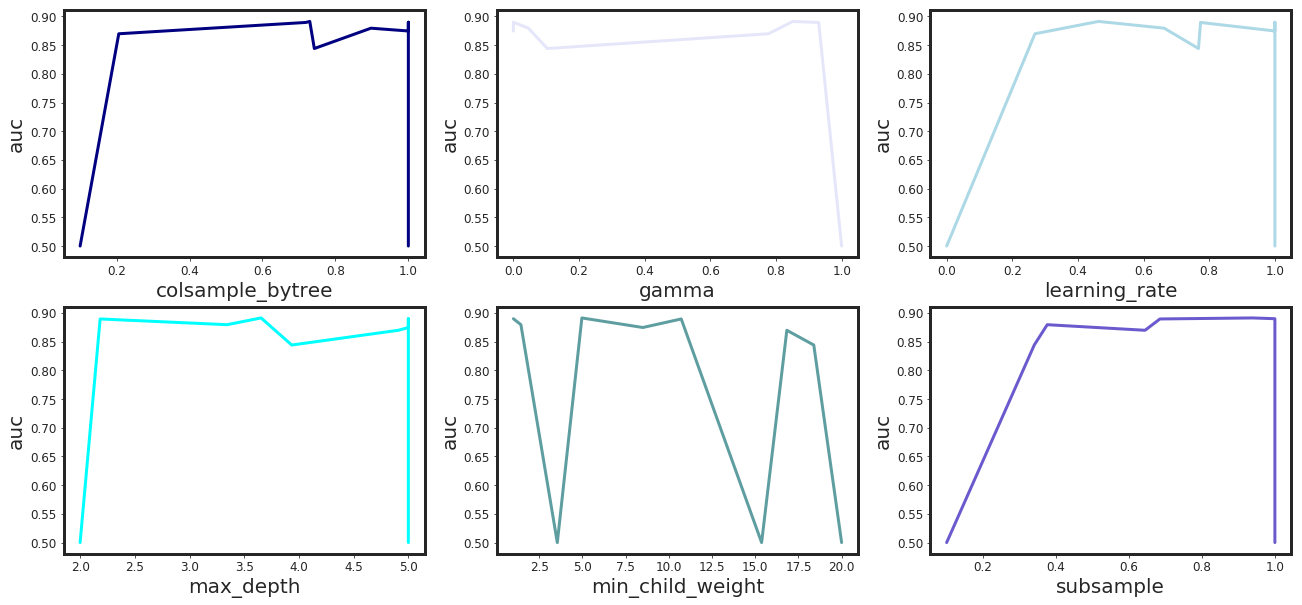

-*-*-*-*-*-* Best Performance -*-*-*-*-*-*


,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,subsample,auc
4,0.729727,0.851274,0.462704,3.654198,4.964748,0.939488,0.891218


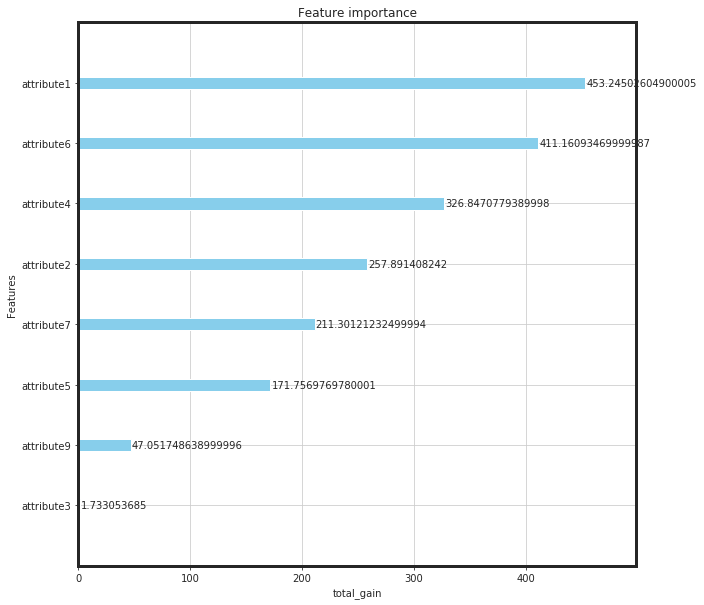

In [6]:
df_res, params = _my_bayesian_optimization(df_X, Y)

# Best XGBoost Parameters

In [9]:
params

{'eval_metric': 'auc',
 'tree_method': 'hist',
 'objective': 'binary:logistic',
 'max_delta_step': 1,
 'silent': 1,
 'nthread': 4,
 'scale_pos_weight': 1,
 'reg_alpha': 0.0,
 'reg_lambda': 1.0,
 'learning_rate': 0.46270355802290863,
 'max_depth': 3,
 'min_child_weight': 4.964747561175287,
 'gamma': 0.8512735546087907,
 'subsample': 0.9394881696342923,
 'colsample_bytree': 0.7297272989171456}